# DESCRIPTORES DE TEXTURA   

Un *descriptor de textura* se define como un método informático para capturar las características generales de las texturas y describir su similitud.    
Implica analizar patrones, direccionalidad y regularidad en imágenes de textura para proporcionar una representación estadística de la misma.   

En este notebook se presentan varios métodos para obtener información de imágenes haciendo uso de este tipo de descriptores.

## Selección de determinadas áreas/regiones

1. En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu

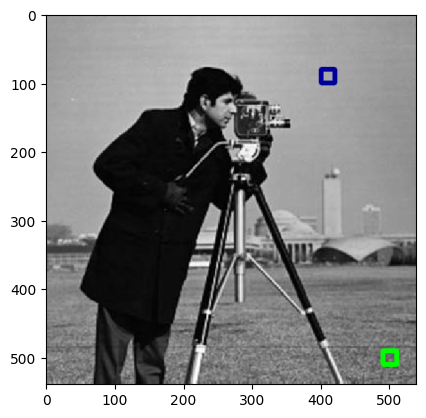

In [1]:

import matplotlib.pyplot as plt
import cv2
import numpy as np
img = cv2.imread('./img/photographer.png')

window = cv2.rectangle(img.copy(), (400,80), (420,100), (0, 0, 155), 5)
window = cv2.rectangle(window, (490,490), (510,510), (0, 255, 0), 5)
plt.imshow(window, cmap='gray')
plt.show()

2. Seleccionamos una región del cielo y una de la hierba

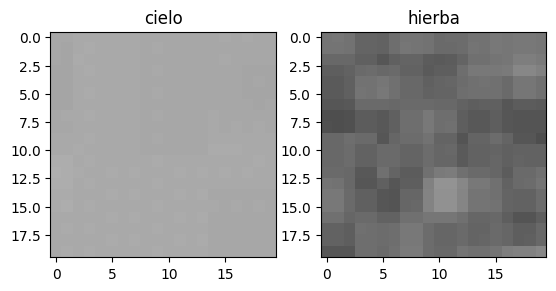

In [2]:

cielo = img[80:100, 400:420]
hierba = img[490:510, 490:510]

fig, ax = plt.subplots(1,2)
ax[0].imshow(cielo, cmap='gray')
ax[0].set_title('cielo')
ax[1].imshow(hierba, cmap='gray')
ax[1].set_title('hierba')
plt.show()


3. Aplicamos GLCM   

NOTA:   
**GLCM (Gray Level Co-occurrence Matrix)** (Matriz de Co-ocurrencia de Niveles de Gris)
La matriz de coocurrencias mide la frecuencia en la que un píxel con nivel de intensidad `i` es adyacente de un píxel con nivel de intensidad `j`.   

La adyacencia se define a través de un número de píxeles vecinos `d` y una orientación (ángulo, `𝜶`).    

A partir de estos valores, es posible extraer diferentes características como: el contraste, la correlación, la disimilitud, la homogeneidad, la energía y el ASM (Angular Second Moment, también conocido como Energía o Uniformidad).   

<img src="./img/GLCM.jpg">

**Pasos básicos para generar la GLCM:**
1. Definir una distancia y dirección (0°, 45°, 90°, 135°).
2. Contar las ocurrencias de pares de niveles de gris vecinos.
3. Normalizar la matriz resultante.   

<img src="./img/glcm2.jpg">


In [6]:

from tabulate import tabulate
from skimage.feature import graycomatrix, graycoprops
headers = ['Propiedad','cielo', 'hierba']
CN, DIS, H, ASM, E, COR = ['contraste'], ['disimilitud'], ['homogeneidad'], ['ASM'], ['Energía'], ['Correlación']

patches = []
patches.append(cielo)
patches.append(hierba)

for i in range(len(patches)):
    image = cv2.cvtColor(patches[i], cv2.COLOR_BGR2GRAY)
    GLCM = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    CN.append(graycoprops(GLCM, 'contrast')[0,0])
    DIS.append(graycoprops(GLCM, 'dissimilarity')[0,0])
    H.append(graycoprops(GLCM, 'homogeneity')[0,0])
    ASM.append(graycoprops(GLCM, 'ASM')[0,0])
    E.append(graycoprops(GLCM, 'energy')[0,0])
    COR.append(graycoprops(GLCM, 'correlation')[0,0])

my_data = [tuple(CN), tuple(DIS), tuple(H), tuple(ASM), tuple(E), tuple(COR)]

print(tabulate(my_data, headers=headers))

Propiedad        cielo        hierba
------------  --------  ------------
contraste     3.68      333.393
disimilitud   1.4        13.8533
homogeneidad  0.512471    0.0921279
ASM           0.142717    0.00510556
Energía       0.377779    0.0714532
Correlación   0.190521   -0.0705127


## Algoritmo SIFT (Scale-Invariant Feature Transform)   

El algoritmo SIFT se utiliza en aplicaciones que involucran un escalado de la imagen. Sirve para la detección de esquinas, bordes o texturas, siendo estable frente a perturbaciones y transformaciones que pueda sufrir la imagen. Es invariante a posición, escala, rotación, iluminación y contraste.    

El algoritmo consta de las siguientes fases:    


1. **Detección de extremos en la escala-espacio**. La escala-espacio se crea aplicando convoluciones entre la imagen original (I) y un kernel gaussiano (G) con diferentes escalas (𝜎).   
<img src="./img/SIFT.jpg" width=400>   

Todas las imágenes (`L`) generadas forman una “octave”. Este proceso se repite para obtener varias “octaves”, donde el tamaño de cada una de ellas es la mitad de la anterior.   

<img src="./img/octave.jpg" width=300>   

2. **Diferencia de Gausianas (DOG)**. Se genera un set de imágenes basado en la diferencia de las imágenes tras ser convolucionadas con el kernel gausiano. Estas diferencias de gausianas son muy buenas para encontrar puntos de interés en las imágenes. El procedimiento se aplica para todas las octaves como la diferencia entre una imagen con dos escalas diferentes, por ejemplo, 𝜎 y k𝜎.   

<img src="./img/octave2.jpg" width=500>

3. **Detección de posibles puntos de interés**. Cada píxel de una imagen es comparada con los 8 píxeles vecinos de esa misma imagen, y con los 9 píxeles (en esa misma posición) en las escalas directamente posterior y anterior. Si el valor del píxel es un extremo local, ese píxel se convierte en un posible punto de interés.   

4. **Localización de puntos de interés**. El punto anterior genera muchos posibles puntos de interés, por lo que en este paso hay que quedarse únicamente con los que son útiles. Se utilizan series de Taylor para conseguir una localización más precisa de los extremos, tal que, si dicho extremo tiene una intensidad menor que un determinado umbral (0.03), se rechaza. Además, la Diferencia de Gausianas (DoG) presenta una alta respuesta para bordes, por lo que estos también tienen que ser eliminados. Para ello, se utilizan una “Hessian matrix (H)” de 2x2 para obtener la curvatura principal.    

5. **Asignación de la orientación**. Una vez ya tenemos localizados los puntos de interés y sabemos que son estables frente a cambios de escala, asignamos una orientación a cada punto de interés para hacerlo invariante a las rotaciones. Se selecciona un vecindario alrededor de un punto de interés y se calcula la magnitud y la dirección del gradiente. La orientación se calcula mediante un histograma de 36 bins que cubre los 360 grados. Si por ejemplo la dirección del gradiente en un punto es 18.7589 grados, esto corresponde al bin 10-19 del histograma. La cantidad que se añade a dicho bin es la magnitud del gradiente. Tras hacer esto con todos los píxeles del vecindario del punto de interés, el histograma tendrá un pico en cada punto. El valor más alto del histograma y aquellos picos mayores del 80% se tienen en cuenta para calcular la orientación. Esto crea puntos de interés con la misma localización y escala, pero diferentes direcciones.

<img src="./img/asignacionOrientacion.jpg" width=400>   

6. **Descriptor del punto de interés**. Una vez cada punto de interés tiene su localización, escala y orientación, es momento de calcular el descriptor que permite identificar un mismo punto en una imagen transformada a partir de la original. Para ello, se coge una ventana de 16x16 alrededor del punto de interés. Dicha ventana se divide en bloques de 4x4 y para cada bloque, se calcula un histograma de orientación de 8bins. De esta manera, se obtienen 16 histogramas de 8 bins, dando lugar a un figerprint de 128 características.   

<img src="./img/fondoInteres.jpg">

(1672, 128)


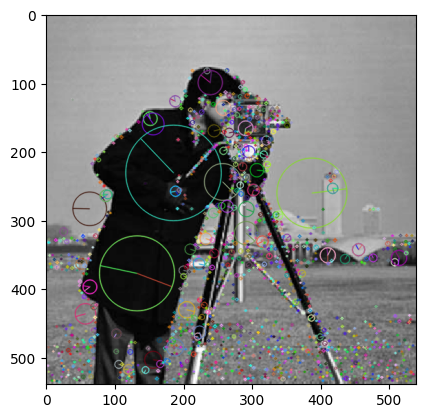

In [ ]:
# SIFT algorithm
img = cv2.imread('./img/photographer.png')

# Definición del algoritmo
sift = cv2.SIFT_create()

# Identificamos los puntos de interés
kp = sift.detect(img, None)

# Extraemos el descriptor para obtener el fingerprint
kp, des = sift.compute(img, kp)
print(np.shape(des))

# Visualizamos los puntos de interés
img=cv2.drawKeypoints(img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

## Histograma de Gradientes Orientados (HOG - Histogram of Oriented Gradients)   

El histograma de gradientes utiliza la distribución de la dirección de los gradientes como características, ya que la magnitud del gradiente presenta una alta respuesta a los cambios de intensidad elevados. Esto permite obtener información sobre la forma de los objetos.

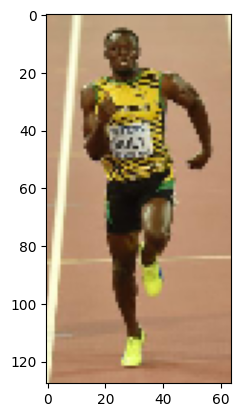

In [8]:
# Algoritmo HOG
# En primer lugar, obtenemos la máscara de la imagen original mediante la umbralización con Otsu
from skimage import io
img = io.imread('./img/pedestrian.jpg')
img = np.float32(img/255)
crop = img[75:550,475:700]
crop = cv2.resize(crop, (64, 128))

plt.imshow(crop, cmap='gray')
plt.show()

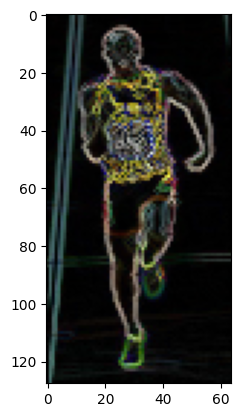

In [9]:
# Calculamos el gradiente con el kernel de Sobel
crop = np.float32(crop)
gx = cv2.Sobel(crop, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(crop, cv2.CV_32F, 0, 1, ksize=1)

# Calculamos la magnitud y la dirección del gradiente
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

mag = mag/np.max(mag)
plt.imshow(mag)
plt.show()

In [ ]:
# Cálculo del Histogram of Oriented Gradients
from skimage.feature import hog
H = hog(crop, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",channel_axis=-1)
np.shape(H) # Mostramos la dimensión del vector de características

(3780,)

## Local Binary Patterns (LBP)    

Los **Local Binary Patterns (LBP)** consisten en un operador que describe patrones de la imagen a nivel local, proporcionando buenos resultados en aplicaciones de reconocimiento de texturas y en identificación de objetos y formas. 

El algoritmo para extraer los LBP consiste en un protocolo de ventana deslizante donde el valor del píxel central se modifica a partir del valor de intensidad de sus píxeles vecinos.    
- Paso1. Se calcula la diferencia de intensidad entre los píxeles vecinos y el píxel central. 
- Paso2. Se construye una matriz auxiliar a partir de la umbralización de las diferencias con 0s en los valores negativos y 1s en los positivos. 
- Paso3. La matriz construida da lugar a una cadena binaria que se multiplica por una matriz de referencia. 
- Paso4. Se suman todos los valores que resultan de la multiplicación anterior y se establece el valor del píxel central.

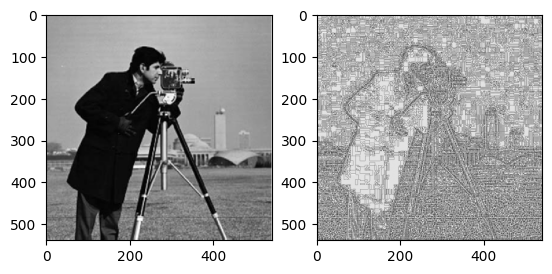

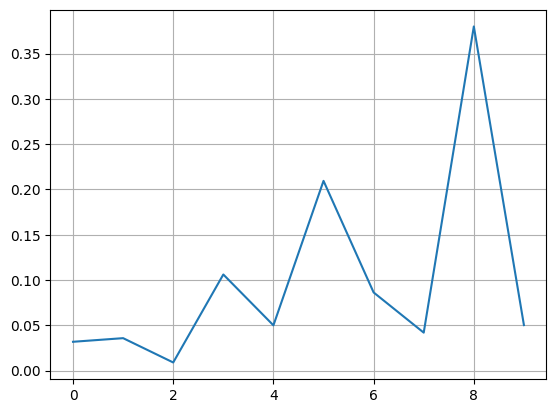

In [12]:
# LOCAL BINARY PATTERNS

from skimage.feature import local_binary_pattern
img = cv2.imread('./img/photographer.png')

# Definimos los parámetros iniciales
R = 1 # Radio
P = 8*R # Número de píxeles vecinos
epsilon = 1e-7 # Para normalizar el histograma

# Extraemos la imagen LBP
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lbp_image = local_binary_pattern(img_gray, P, R, method='uniform')
a,b = np.unique(lbp_image, return_counts=True)

# Calculamos el histograma
lbp_image = np.uint8(lbp_image)
hist = cv2.calcHist([lbp_image.ravel()], [0], None, [P+2], [0, P+2])

# Normalizamos el histograma
hist = hist.astype("float")
hist /= (hist.sum() + epsilon)

# Visualizamos la imagen LBP
figs, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbp_image, cmap='gray')
plt.show()

# Visualizamos el histograma
plt.plot(hist)
plt.grid(True)
plt.show()